# Описание проекта


Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

# Описание данных

Данные состоят из файлов, полученных из разных источников:
Данные состоят из файлов, полученных из разных источников:

- contract.csv — информация о договоре;
- personal.csv — персональные данные клиента;
- internet.csv — информация об интернет-услугах;
- phone.csv — информация об услугах телефонии



Описание полей данных:
- BeginDate – дата начала пользования услугами,
- EndDate – дата окончания пользования услугами,
- Type – тип оплаты: ежемесячный, годовой и тд,
- PaperlessBilling – безналичный расчет,
- PaymentMethod – способ оплаты,
- MonthlyCharges – ежемесячные траты на услуги,
- TotalCharges – всего потрачено денег на услуги
- Dependents – наличие иждивенцев
- Senior Citizen – наличие пенсионного статуса по возрасту
- Partner – наличие супруга(и)
- MultipleLines – наличие возможности ведения параллельных линий во время звонка

In [3]:
import sweetviz as sv
import pandas as pd
import numpy as np 
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')
RANDOM_STATE = 12345

In [4]:
df_con = pd.read_csv('/datasets/final_provider/contract.csv')
df_int = pd.read_csv('/datasets/final_provider/internet.csv')
df_pers = pd.read_csv('/datasets/final_provider/personal.csv')
df_phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [6]:
#df_con = pd.read_csv('C:/Users/VovAz/Desktop/Проект/Финальный проект/contract.csv')

df_con.info()

df_con['TotalCharges'] = pd.to_numeric(df_con['TotalCharges'], errors='coerce')
df_con['BeginDate'] = pd.to_datetime(df_con['BeginDate'], format='%Y-%m-%d')
df_con['EndDate'] = pd.to_datetime(df_con['EndDate'], format='%Y-%m-%d', errors='coerce')

#report_con = sv.analyze([df_con, "contract"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


In [3]:
report_con.show_html()

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Изучили данные по контрактам. 4 категориальных столбца, 2 столбца с датами в формате obj, нужно заменить на формат DateTime.Формат столбца TotalCharges - obj, требуется изменение формата на float. Пропусков и дубликатов нет. В стобце EndDate 5 уникальных значений, 73% значений - no, что может означать, что данные клиенты активны. В столбце MonthlyCharges изучили значения минимальных и максимальных значений, значение дисперсии, стандартного отклонения, данные сбаланисрованы, с пологими пиками и хвостом, направленным к отрицательным значениям.
\n
В столбце TotalCharges после замены формата были утеряны 11 значений, изучили значения минимальных и максимальных значений, значение дисперсии, стандартного отклонения,, данные в нем сбалансированы, сильных выбросов нет, с пологими пиками и хвостом, направленным к положительным значениям.

In [4]:
#df_int = pd.read_csv('C:/Users/VovAz/Desktop/Проект/Финальный проект/internet.csv')
report_int = sv.analyze([df_int, "internet"])
report_int.show_html()
df_int.info()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Данные с интернет пользователями содержат категориальные значения, пропусков и дубликатов нет, требуется только обработка с помощью ohe.

In [5]:
df_pers = pd.read_csv('C:/Users/VovAz/Desktop/Проект/Финальный проект/personal.csv')
report_pers = sv.analyze([df_pers, "personal"])
report_pers.show_html()
df_pers.info()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


В данной таблице содержатся данные о пользователях: о его поле, имеются ли партнеры, иждивенцы и является ли клиент пенсионером. Пропусков и дубликатов нет.

In [6]:
#df_phone = pd.read_csv('C:/Users/VovAz/Desktop/Проект/Финальный проект/phone.csv')
report_phone = sv.analyze([df_phone, "phone"])
report_phone.show_html()
df_phone.info()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


В данной талице содержатся данные о том пользуется ли клиент несколькими линиями, поскольку количество значений в таблице меньше, чем в основной предлагается заменить пропуски значением 'No'. 

# План
##  Соединить таблицы.
### Для того, чтобы собрать в одну таблицу данные по клиентам.
## Заполнить недостающие значения.
### И изменить значение целевого признака на булев тип для отслеживания ухода клиентов
##  Провести кодирование категориальных признаков.
##  Разделить выборку на тестовую и тренировочную, в тренировочной провести балансировку классов.
##  Обучить модели.

In [7]:
df_con = df_con.rename(columns={'customerID': 'CustomerID'})
print(df_con.columns.values)

['CustomerID' 'BeginDate' 'EndDate' 'Type' 'PaperlessBilling'
 'PaymentMethod' 'MonthlyCharges' 'TotalCharges']


In [8]:
df_pers = df_pers.rename(columns={'customerID': 'CustomerID', 'gender': 'Gender'})
print(df_pers.columns.values)

['CustomerID' 'Gender' 'SeniorCitizen' 'Partner' 'Dependents']


In [9]:
df_int = df_int.rename(columns={'customerID': 'CustomerID'})
print(df_int.columns.values)

['CustomerID' 'InternetService' 'OnlineSecurity' 'OnlineBackup'
 'DeviceProtection' 'TechSupport' 'StreamingTV' 'StreamingMovies']


In [10]:
df_phone = df_phone.rename(columns={'customerID': 'CustomerID'})
print(df_phone.columns.values)

['CustomerID' 'MultipleLines']


Привели названия столбцов к единому виду.

In [11]:
df_con['Churn'] = (df_con['EndDate'].notna()).astype(bool)
df_con

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,False
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,False
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,True
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,False
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,True
...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,NaT,One year,Yes,Mailed check,84.80,1990.50,False
7039,2234-XADUH,2014-02-01,NaT,One year,Yes,Credit card (automatic),103.20,7362.90,False
7040,4801-JZAZL,2019-03-01,NaT,Month-to-month,Yes,Electronic check,29.60,346.45,False
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,True


Создали новый столбец с оттоком клиентов значение True - означает, что клиент ушёл от оператора.

In [12]:
df_con['EndDate'] = df_con['EndDate'].fillna('2020-02-01')
df_con['EndDate'] = pd.to_datetime(df_con['EndDate'], format='%Y-%m-%d')
df_con.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Churn             7043 non-null   bool          
dtypes: bool(1), datetime64[ns](2), float64(2), object(4)
memory usage: 447.2+ KB


Для исчисления срока пользования клиентом услугами компании заполнили пропуски датой выдачи отчета.

In [13]:
df_con['TotalDays'] = (df_con['EndDate'] - df_con['BeginDate']).dt.days
df_con

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalDays
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,False,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,False,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,True,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,False,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,True,61
...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.50,False,730
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.90,False,2191
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,False,337
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,True,123


Столбец с количеством дней добавили, осталось обработать 11 пропусков в столбце TotalCharges.

In [14]:
df_con[df_con['TotalCharges'].isnull()]

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalDays
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,False,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,False,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,False,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,False,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,False,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,False,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,False,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,False,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,False,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,False,0


Очевидно, что это новые клиенты, подключившиевся в день выгрузки отчета, соответственно, они еще не успели понести расходов, предлагается заменить пропуски на 0. 

In [15]:
df_con['TotalCharges'] = df_con['TotalCharges'].fillna(0)
df_con.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   bool          
 9   TotalDays         7043 non-null   int64         
dtypes: bool(1), datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 502.2+ KB


In [16]:
df_total  = df_con.merge(df_pers, 
                             how='left',
                        on='CustomerID').merge(df_int,
                                               how='left', on='CustomerID').merge(df_phone, how='left', on='CustomerID')

In [17]:
df_total = df_total.set_index('CustomerID')

In [18]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   Churn             7043 non-null   bool          
 8   TotalDays         7043 non-null   int64         
 9   Gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   5517 non-null   object        
 14  OnlineSecurity

Одинаковое количество пропусков в InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies и MultipleLines скорее всего означают, что услуги не подключены. Заменим пропуски на "No"

In [19]:
for i in ('InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'):
    df_total[i] = df_total[i].fillna('No')

In [20]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   Churn             7043 non-null   bool          
 8   TotalDays         7043 non-null   int64         
 9   Gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   7043 non-null   object        
 14  OnlineSecurity

In [21]:
report_total = sv.analyze([df_total, "total"])
report_total.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Исследовательский анализ данных

In [22]:
report_total = sv.analyze([df_total, "total"])
report_total.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


С помощью sweetviz проводим исследовательский анализ данных:
- среди пользователей наиболее популярен помесячный тип оплаты - 55%, на втором месте - двухлетний контракт 24%, на последнем - годовой - 21%.
- пользователи предпочитают безналичный расчет - 59%.
- клиенты предпочитают платить электронным чеком - 34%, переводом, кредитной картой или по почте препочитают платить 22%
- ежемесячно пользователи платят от 18 до 119 долларов, наиболее популярны самые дешевые тарифы - ими пользуются 23% пользователей, далее мы наблюдаем второй пик в районе 55 долларов в месяц - 9% пользователей и третий  - в районе 85 долларов - 14%. Данные распределены с пологим пиком и хвостом к отрицательным значениям. Среднее значение - 65 долларов в месяц, медианное - 70, модальное - 20 долларов.
- в столбце TotalDays наблюдаем два пика - в районе 0-100 и в районе 2200 это означает что привлечено много новых клиентов и существует много лояльных клиентов, которые пользуются услугами с начала наблюдений.
- клиентов мужчин и клиентов женщин 50/50
- клиентов пенсионеров 16%
- не пользуются интернетом от компании - 22% клиентов
- набором дополнительных услуг пользубтся 20-40 % клиентов

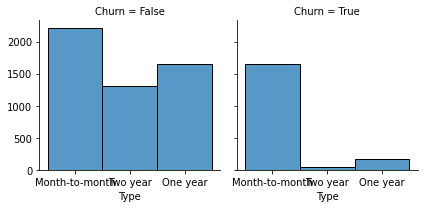

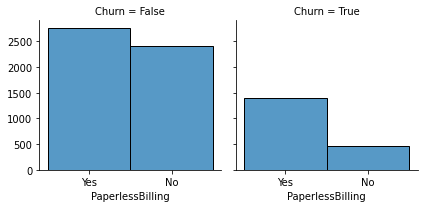

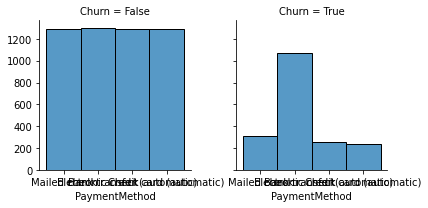

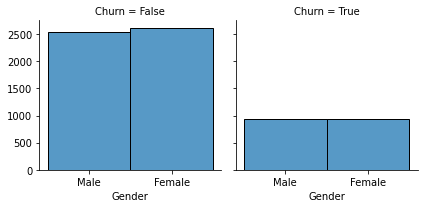

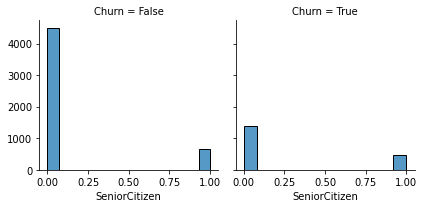

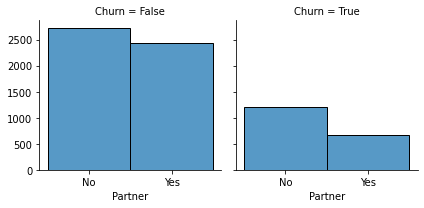

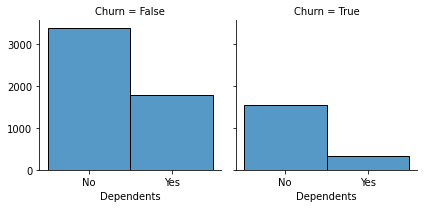

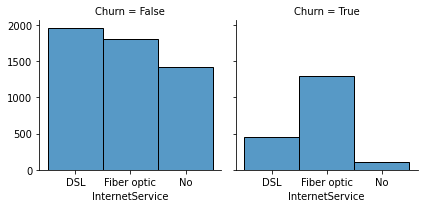

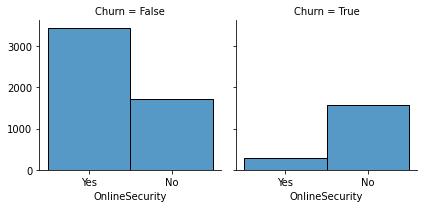

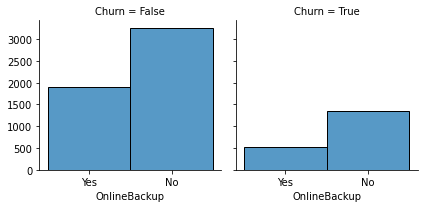

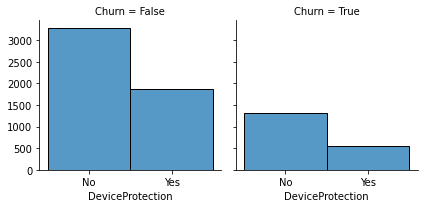

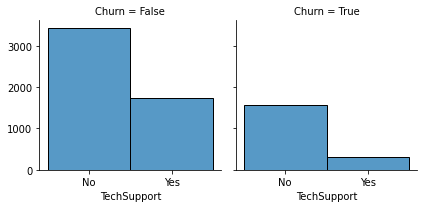

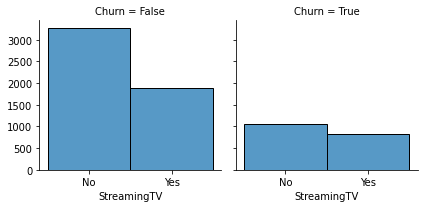

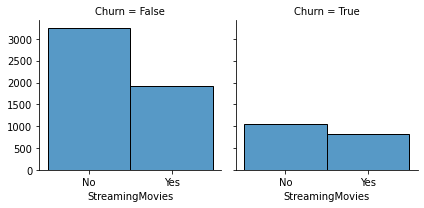

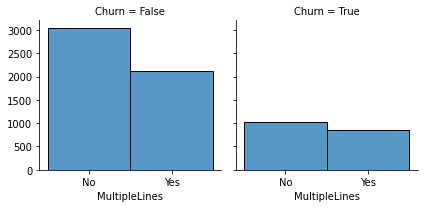

In [21]:
for i in [
    'Type',
    'PaperlessBilling',
    'PaymentMethod',
    'Gender',
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'InternetService', 
    'OnlineSecurity', 
    'OnlineBackup', 
    'DeviceProtection', 
    'TechSupport', 
    'StreamingTV', 
    'StreamingMovies', 
    'MultipleLines'
]:
    
    g = sns.FacetGrid(df_total, col="Churn")
    g.map(sns.histplot,  i)

Рассмотрим распределение признаков в зависимости от того - покинул клиент компанию или нет.
- Среди тех кто покинул компанию большинство пользователей тарифов с ежемесячным списанием
- Выше доля тех, кто пользуется безналичным расчетом и электронным чеком
- Пенсионеры покидают компанию несколько чаще, как и люди без партнера
- Заметно высока доля людей с оптоволоконным соединением и стриминговым телевидением и кино - можно предположить что их не устраивает качество


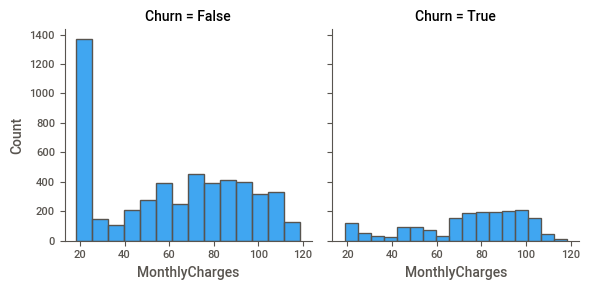

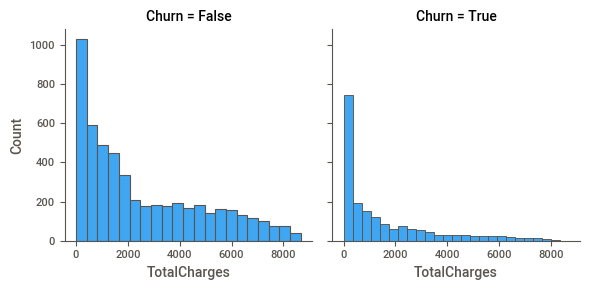

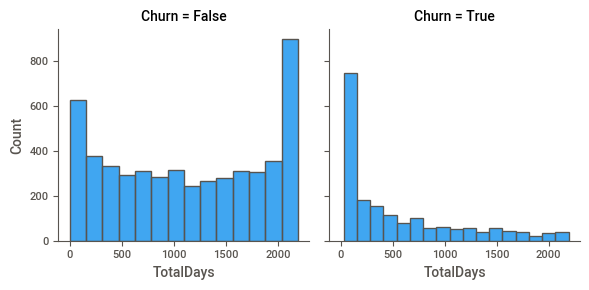

In [24]:
for i in ['MonthlyCharges', 'TotalCharges', 'TotalDays']:
    
    g = sns.FacetGrid(df_total, col="Churn")
    g.map(sns.histplot,  i)

Исходя из анализа количественных значений можно сделать следующие выводы:
- Чаще покидают компанию те, кто платит больше.
- Чаще уходят новые клиенты.

# Обучение модели

In [22]:
del df_total['BeginDate'], df_total['EndDate']
df_total = pd.get_dummies(df_total, drop_first=True)
features = df_total.drop(['Churn'], axis =1)
target = df_total['Churn']


In [23]:
df_total

,MonthlyCharges,TotalCharges,Churn,TotalDays,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,...,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
CustomerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,29.85,29.85,False,31,0,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
5575-GNVDE,56.95,1889.50,False,1036,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3668-QPYBK,53.85,108.15,True,61,0,0,0,1,0,0,...,0,0,0,1,1,0,0,0,0,0
7795-CFOCW,42.30,1840.75,False,1371,0,1,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0
9237-HQITU,70.70,151.65,True,61,0,0,0,1,0,1,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,84.80,1990.50,False,730,0,1,0,1,0,0,...,1,0,0,1,0,1,1,1,1,1
2234-XADUH,103.20,7362.90,False,2191,0,1,0,1,1,0,...,1,1,0,0,1,1,0,1,1,1
4801-JZAZL,29.60,346.45,False,337,0,0,0,1,0,1,...,1,0,0,1,0,0,0,0,0,0


Провели кодирование категориальных признаков.

In [24]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE)

In [25]:
scaler = StandardScaler()

scaler.fit(features_train[['MonthlyCharges', 'TotalCharges', 'TotalDays']])

features_train = features_train.copy()
features_train[['MonthlyCharges', 'TotalCharges', 'TotalDays']] = scaler.transform(features_train[['MonthlyCharges', 'TotalCharges', 'TotalDays']])

features_test = features_test.copy()
features_test[['MonthlyCharges', 'TotalCharges', 'TotalDays']] = scaler.transform(features_test[['MonthlyCharges', 'TotalCharges', 'TotalDays']])

Провели масштабирование признаков

In [26]:
target.value_counts()

False    5174
True     1869
Name: Churn, dtype: int64

Наблюдаем примерно трехкратный дисбаланс классов. Проведем upsampling.

In [27]:
def upsample(features, target, repeat):     
    features_zeros = features.loc[target == 0]     
    features_ones = features.loc[target == 1]     
    target_zeros = target.loc[target == 0]     
    target_ones = target.loc[target == 1] 

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)     
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)     
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=RANDOM_STATE)          
    
    return features_upsampled, target_upsampled

In [28]:
features_train, target_train = upsample(features_train, target_train, 3)

Данные готовы для обучения

In [31]:

cv = 5
models = [DecisionTreeClassifier(random_state = RANDOM_STATE), 
          RandomForestClassifier(random_state=RANDOM_STATE), 
          LogisticRegression(), CatBoostClassifier(random_state=RANDOM_STATE,verbose = 0),LGBMClassifier(random_state=RANDOM_STATE) ]


results_cross_val = []

for model in models:     
    
    train_start = time.time()
        
    cross_val_score_mod = cross_val_score(model, 
                                              features_train, 
                                              target_train, 
                                              cv=cv, scoring='roc_auc').mean()

    train_end = time.time()
    results_cross_val.append({'model_name': model.__class__.__name__, 
                              'cross_val_score': cross_val_score_mod, 
                              'training time ': train_end - train_start
                              })  
              
res = pd.DataFrame(results_cross_val)
res

,model_name,cross_val_score,training time
0,DecisionTreeClassifier,0.906001,0.211003
1,RandomForestClassifier,0.984087,2.968027
2,LogisticRegression,0.849099,0.138968
3,CatBoostClassifier,0.946268,22.489456
4,LGBMClassifier,0.950502,0.720999


Выберем три наиболее перспективные модели для обучения. Это - рандомный лес, Кэтбуст и ЛГБМ.

{'depth': 10, 'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.5, 'random_state': 12345, 'verbose': 0}


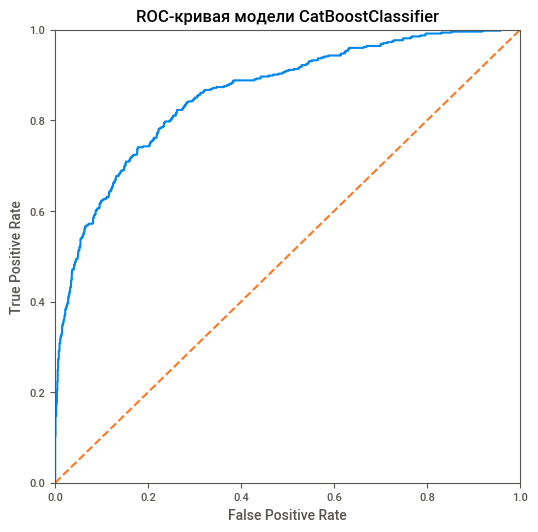

Значение ROC-AUC 0.8595300620617077


In [32]:
train_start = time.time()
model = CatBoostClassifier() 

hyperparams = [{'learning_rate':[0.1, 0.3, 0.5, 0.9],
                'depth':[x for x in range(1, 11, 3)],
                'random_state':[RANDOM_STATE],
              'verbose':[0],
                  'iterations': [50, 100],
    'l2_leaf_reg': [3, 9]}]

search = GridSearchCV(model, hyperparams, cv=5, scoring='roc_auc')
search.fit(features_train, target_train)

print(search.best_params_)

predicted_probalities = search.best_estimator_.predict_proba(features_test)[:, 1]
roc_auc = roc_auc_score(target_test, predicted_probalities)
fpr, tpr, thresholds = roc_curve(target_test, predicted_probalities)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('ROC-кривая модели {}'.format(model.__class__.__name__))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()
print('Значение ROC-AUC',roc_auc)

{'max_depth': 19, 'n_estimators': 9, 'random_state': 12345}


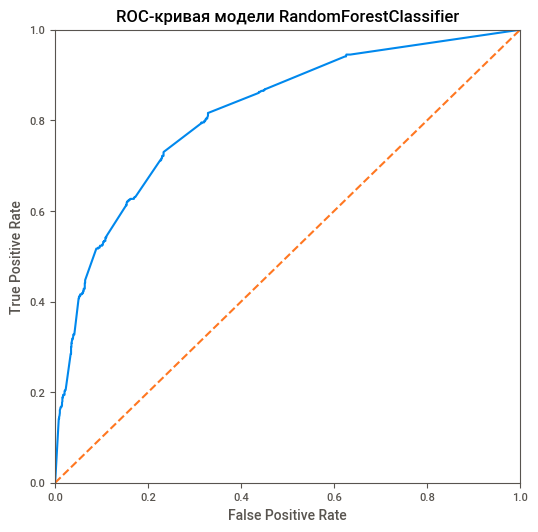

Значение ROC-AUC 0.8166589622285825


In [33]:
train_start = time.time()
model = RandomForestClassifier() 
hyperparams = [{'n_estimators' : [x for x in range(1, 10)], 
                'max_depth':[x for x in range(1, 20)], 
                'random_state':[RANDOM_STATE]}]

search = GridSearchCV(model, hyperparams, cv=5, scoring='roc_auc')
search.fit(features_train, target_train)

print(search.best_params_)

predicted_probalities = search.best_estimator_.predict_proba(features_test)[:, 1]
roc_auc = roc_auc_score(target_test, predicted_probalities)
fpr, tpr, thresholds = roc_curve(target_test, predicted_probalities)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('ROC-кривая модели {}'.format(model.__class__.__name__))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()
print('Значение ROC-AUC',roc_auc)

{'max_depth': 11, 'num_leaves': 101, 'random_state': 12345}


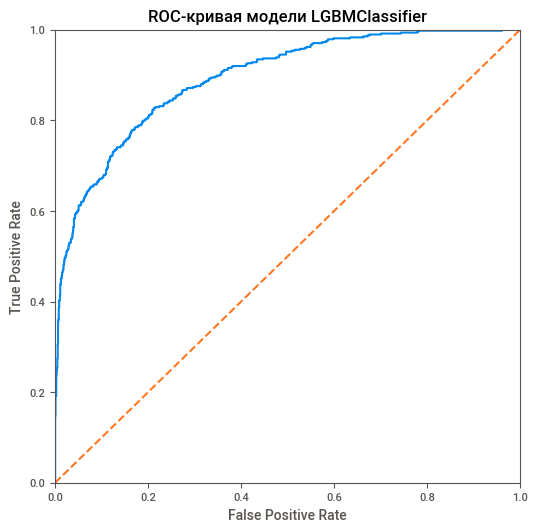

Значение ROC-AUC 0.8930927253712064


In [34]:
train_start = time.time()
model = LGBMClassifier() 

hyperparams = [{'num_leaves' : [x for x in range(1, 102, 20)], 
                'max_depth':[x for x in range(1, 12, 2)],
                'random_state':[RANDOM_STATE]}]



search = GridSearchCV(model, hyperparams, cv=5, scoring='roc_auc')
search.fit(features_train, target_train)

print(search.best_params_)

predicted_probalities = search.best_estimator_.predict_proba(features_test)[:, 1]
roc_auc = roc_auc_score(target_test, predicted_probalities)
fpr, tpr, thresholds = roc_curve(target_test, predicted_probalities)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('ROC-кривая модели {}'.format(model.__class__.__name__))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()
print('Значение ROC-AUC',roc_auc)

Рандомный лес, несмотря на лидерство при кросс-валидации показал себя хуже трех моделей: налицо переобучение.
ЛГБМ показал результат ROC-AUC 0,89 против ROC-AUC 0,86 у КэтБуста, предлагается использовать данную модель для пресказаний.
Осталось изучить какие признаки влияют на принятие решения моделью.

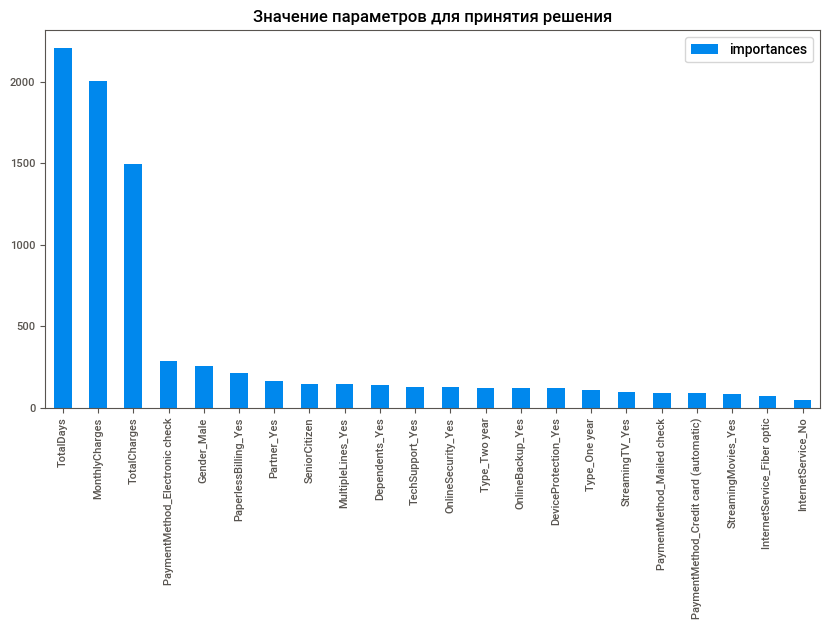

In [36]:
importances = pd.DataFrame(search.best_estimator_.feature_importances_, index = features_test.columns, columns=['importances'])
importances = importances.sort_values(by='importances', ascending=False)
importances.plot(kind='bar', figsize=(10, 5), title='Значение параметров для принятия решения')
plt.show()

Наиболее сильно на решение покинуть компанию влияет: срок пользования услугами, месячный тариф и общие траты по услугам.

# Отчет
- Требовалось провести работу по предсказанию того, откажется ли клиент от услуг оператора сотовой связи или нет.
- Сначала данные были прочитаны и по ним были сделаны предварительные выводы
- После этого была произведена первичная обработка данных - переименованы столбцы, изменены типы данных
- Были добавлены 2 новых столбца - целевой признак Churn, который означает отказался ли клиент от услуг и TotalDays, который обозначает сколько по времени пользователь пользовался услугами
- После этого был проведен исследовательский анализ данных - проанализированы количественные и категориальные признаки
- Были сделаны следующие выводы: со временем вероятность отказа от услуг снижается и обычно отказывались от услуг те, кто платил больше
- После этого была проведена подготовка данных к обучению моделей: удалены ненужные столбцы, применена техника OHE, датафрейм был разделен на обучающую и тестовую выборки, проведено масштабирование количественных признаков и проведен upsample
- Затем на данных были обучены 3 модели из самых перспективных: ЛГБМ, Рандомный лес и КэтБуст
- Лучший результат показала модель ЛГБМ со значением метрики ROC-AUC в 0.89, что выше, чем значение, требуемое в задании
- Самые важные факторы - сколько клиент пользуется услугами и сколько он платит в месяц и общие траты по услугам.